# import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy.integrate import odeint
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Func

In [6]:
def nuke_Epa(x):
    if (abs(x) <= 1):
        return 3/4 * (1-x**2)
    else:
        return 0
    
def nuke_Epa_der(x):
    if (abs(x) <= 1):
        return (-3*x)/2
    else:
        return 0
    
def h_estimate_opt(X_pred, x_train, y_train, par_blur, nuke_der, T):
    def find_borders(x, some_x, par_blur):
        # x - точки диапазона переменной обучающей выборки
        # some_x - точка, значение в которой нужно предсказать
        # par_blur - параметр размытости
        # border_index -  индекс правой границы
        border_index = len(x)-1
        border_value = some_x + 30*par_blur
        for i in range(len(x)):
            if ( x.iloc[i] > border_value ):
                return i
        return border_index
    
    border_index = find_borders(x_train, X_pred, par_blur)
    x_train = x_train[0:border_index]
    y_train = y_train[0:border_index]
    c = 0
    size = len(x_train)
    T = x_train.iloc[-1] - x_train.iloc[0]
    z = T / (size * (par_blur**2))
    for i in range(size):
        c += y_train.iloc[i] * nuke_der((X_pred-x_train.iloc[i])/par_blur)
    return z * c

In [4]:
def u_one(x):
    if (x>=0):
        return 1
    else: return 0

# Pic

In [101]:
def h_pic(data, data_sample):
    fig = plt.figure(figsize =(10, 5))
    ax = plt.axes()
    plt.title('Восстановление поведения с $cos$ и ступенькой')
    ax.plot(data['t'], data['obj1_one'],c='magenta', label='$k$')
    ax.plot(data['t'],data['obj1_one_derivative'],'--', c='magenta', label='$h$')

    ax.plot(data_sample['t'],data_sample['h_estimate'], c='red', label='$\hat{h}$')

    ax.scatter(data_sample['t'], data_sample['obj1_one'],c='#D752FF', s=10)
    ax.scatter(data_sample['t'], data_sample['obj1_one_derivative'],c='#D752FF', s=10)

    plt.legend()
    plt.grid()
    plt.show()

def w_pic(data, data_sample):
    fig = plt.figure(figsize =(10, 5))
    ax = plt.axes()
    plt.title('Восстановление поведения с $cos$ и ступенькой')
    ax.plot(data['t'], data['obj1_one'],c='magenta', label='$k$')
    ax.plot(data['t'],data['obj1_one_derivative'],'--', c='magenta', label='$h$')

    ax.plot(data_sample['t'],data_sample['h_estimate'], c='red', label='$\hat{h}$')

    ax.scatter(data_sample['t'], data_sample['obj1_one'],c='#D752FF', s=10)
    ax.scatter(data_sample['t'], data_sample['obj1_one_derivative'],c='#D752FF', s=10)

    ax.plot(data_sample['t'],data_sample['w_estimate'], c='blue', label='$\hat{w}$')

    ax.set_xlim(0,10)
    ax.set_ylim(-0.2,0.2)
    plt.legend()
    plt.grid()
    plt.show()

# work

In [7]:
T = 11
period = 10
dispersion = 0.01
random_state = 10

In [8]:
def normal_DE(y,x, k0, k1, k2, u):
    z = - k0*y[0] - k1*y[1] - k2*y[2]  + u(x)
    return [ y[1], y[2], z ]

In [9]:
data = pd.DataFrame()

In [25]:
x = np.linspace(0, T, 1000)
data['t'] = x
y0 = [ 0, 0, 0 ]

k0 , k1, k2 = [ 8, 6 , 4 ]
sol1 = odeint(normal_DE, y0, x, args=(k0, k1,k2, u_one))

data['obj1_one'] = sol1[:,0]
data['obj1_one_derivative'] = sol1[:,1]

size = np.shape(data['t'][::period])[0]
data_sample = pd.DataFrame()
# делаем выборку с заданным периодом из всех точек что есть
#добавляем шум к данным
np.random.seed(random_state)
data_sample['t'] = data['t'][::period]
data_sample['obj1_one'] = data['obj1_one'][::period] + dispersion * np.random.normal(0,1,size)*data['obj1_one'][::period] 
data_sample['obj1_one_derivative'] = data['obj1_one_derivative'][::period] + dispersion * np.random.normal(0,1,size)*data['obj1_one_derivative'][::period] 


100%|██████████| 100/100 [00:00<00:00, 421.70it/s]


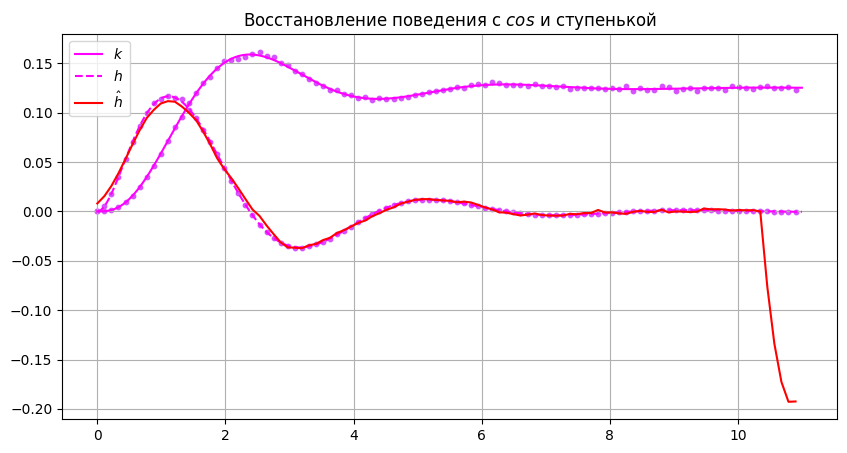

In [54]:
h = []
blur = 0.49
for i in tqdm(range(size)):
    h.append( h_estimate_opt(data_sample['t'].iloc[i], data_sample['t'], data_sample['obj1_one'], blur, nuke_Epa_der,T) )

data_sample['h_estimate'] = h
h_pic(data,data_sample)


In [49]:
data['t'].iloc[1]-data['t'].iloc[0]

0.011011011011011011

In [55]:
data_sample['h_estimate'].iloc[0]

0.008071505291384005

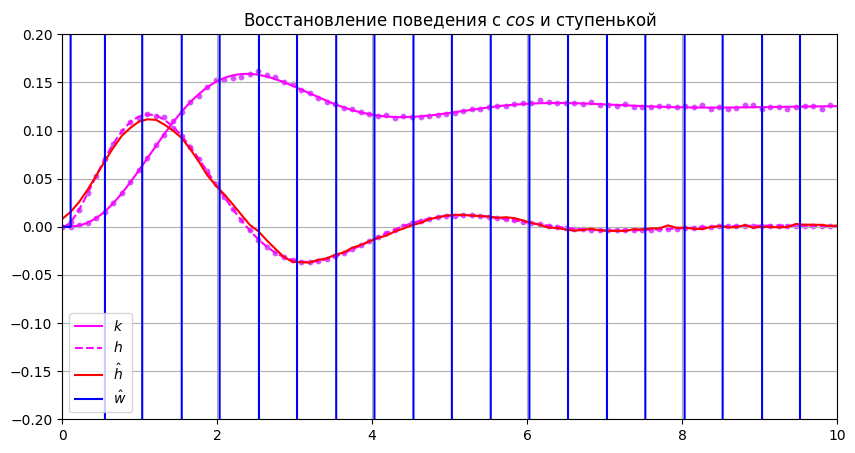

In [ ]:
dt = 0.011011011011011011
size = len(data_sample['h_estimate'])
w = np.array([])
w = np.append(w,0)
for i in range(1,size):
    w=np.append(w,0)
    
    for j in range(i-1):
        w[i] += (1-(data_sample['h_estimate'].iloc[i-j] * w[j]*dt)) / (data_sample['h_estimate'].iloc[0] * dt)
    #w[i] /= data_sample['h_estimate'].iloc[0] * dt

data_sample['w_estimate'] = w
w_pic(data, data_sample)

In [95]:
(1-data_sample['h_estimate'].iloc[1] * 1 * dt)/ (8.071505291384005e-05)


12387.348024476352

np.shape(w)=(1,)
i=1
w_iter=array([], dtype=float64)
w_iter=0.0
f=8.071505291384005e-05
w[-1]=0.0
np.shape(w)=(2,)
i=2
j=0
w_iter=array([1.])
w_iter=1.0
f=8.071505291384005e-05
w[-1]=12389.262769454643
np.shape(w)=(3,)
i=3
j=0
j=1
w_iter=array([1., 1.])
w_iter=2.0
f=8.071505291384005e-05
w[-1]=24778.525538909285
np.shape(w)=(4,)
i=4
j=0
j=1
j=2
w_iter=array([ 1.       ,  1.       , -2.1992404])
w_iter=-0.19924040131250553
f=8.071505291384005e-05
w[-1]=-2468.441686152227
np.shape(w)=(5,)
i=5
j=0
j=1
j=2
j=3
w_iter=array([ 1.        ,  1.        , -3.78971177, -5.3984808 ])
w_iter=-7.188192573155138
f=8.071505291384005e-05
w[-1]=-89056.40662626133
np.shape(w)=(6,)
i=6
j=0
j=1
j=2
j=3
j=4
w_iter=array([ 1.        ,  1.        , -5.58540924, -8.57942354,  1.63741794])
w_iter=-10.527414835852316
f=8.071505291384005e-05
w[-1]=-130426.90868442955
np.shape(w)=(7,)
i=7
j=0
j=1
j=2
j=3
j=4
j=5
w_iter=array([  1.        ,   1.        ,  -7.42844665, -12.17081847,
         1.9543041 ,  23.99675609

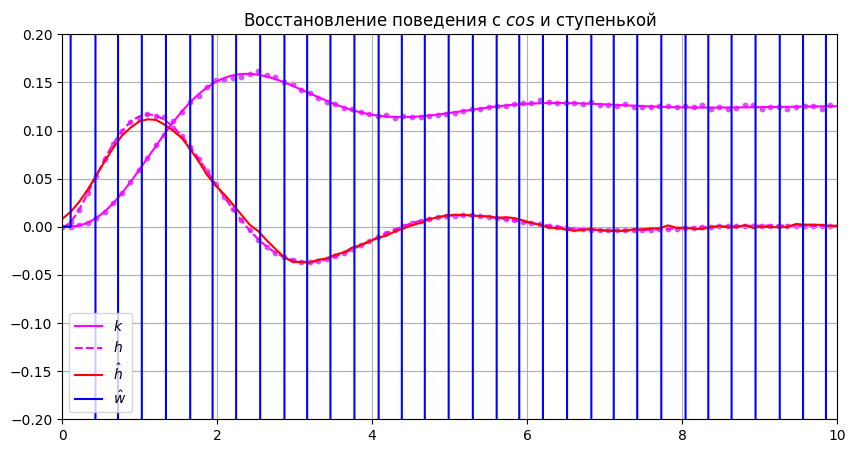

In [112]:
dt = 0.01
size = len(data_sample['h_estimate'])
w = np.array([])
w = np.append(w,0)
for i in range(1,size):
    print(f'{np.shape(w)=}')
    print(f'{i=}')
    w_iter = []
    for j in range(i-1):
        print(f'{j=}')
        w_iter.append(1 - (data_sample['h_estimate'].iloc[i-j] * w[j] * dt))
    w_iter = np.array(w_iter)
    print(f'{w_iter=}')
    w_iter = w_iter.sum()
    print(f'{w_iter=}')
    f = data_sample['h_estimate'].iloc[0] * dt
    print(f'{f=}')
    w = np.append( w, w_iter.sum()/f)
    print(f'{w[-1]=}')
data_sample['w_estimate'] = w
w_pic(data, data_sample)

In [ ]:
w = [0]
for j in range(size):
    